In [50]:
import os
import numpy as np
#Suppress Warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.layers import GRU, LSTM, Input, Dense, Layer, TimeDistributed, 
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import losses
import datetime
import yfinance as yf
from fredapi import Fred

In [51]:
class LSTM_GRU_Layer(Layer):
    def __init__(self, LSTM_units, GRU_units, not_last_layer, *, activity_regularizer=None, trainable=True, dtype=None, autocast=True, name=None, **kwargs):     
        super().__init__(activity_regularizer=None, trainable=True, dtype=None, autocast=True, name=None, **kwargs)
        self.LSTM_layer = LSTM(units=LSTM_units,return_sequences = True, return_state = True, recurrent_dropout = 0.1)
        self.GRU_layer = GRU(units = GRU_units, return_sequences= not_last_layer)
        self.gru_units = GRU_units
        self.lstm_units = LSTM_units
        self.last_layer = not_last_layer
        self.dense_tranfer = Dense(units = GRU_units, activation= "relu")
    
    def build(self, input_shape):
        self.t = input_shape[1]
        self.n = input_shape[2]
        #print(input_shape)
        if not self.last_layer:   # final layer
            self.dense_out = Dense(1)  # (B, N)
        else:
            self.dense_out = TimeDistributed(Dense(self.n))
        
    def call(self, inputs):
        #input dimension (batch, time_steps, num_features)
        out, _, c = self.LSTM_layer(inputs)
        # output have dimesion (time_steps, lstm_units)
        # Dense change lstm units to gru units
        c = self.dense_tranfer(c)
        # Cell state of LSTM plug in to Hidden State of GRU
        out = self.GRU_layer(out, initial_state = c)
        # Make output equal same dimension of inputs
        # If we stack them together, out is (time_steps, num_features)
        out = self.dense_out(out) 

        return out

In [ ]:
class model():
    def __init__(self):
        self.now=datetime.today().date()
        self.api='eb4ae97ea9d3f7c1a40b6f198b459340'
        self.data=self.take_data_api_key(self.api)
        self.select_now=''
        self.assess={}
        self.models = {
            'Linear Regression': LinearRegression(),
            'Support Vector Machine Linear': SVR(kernel='linear'),
            'Support Vector Machine Quadratic': SVR(kernel='poly', degree=2),
            'Support Vector Machine Cubic': SVR(kernel='poly', degree=3),
            'Support Vector Machine Gaussian': SVR(kernel='rbf', gamma='auto'),
            'Gaussian Process Regression Rational Quadratic': GaussianProcessRegressor(kernel=RationalQuadratic(), alpha=1e-5),
            'Gaussian Process Regression Squared Exponential': GaussianProcessRegressor(kernel=RBF(), alpha=1e-5),
            'Ensemble Learning with Decision Trees Bootstrap Aggregation': BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),n_estimators=100,oob_score=True),
            'Ensemble Learning with Decision Trees Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        }
        self.month_dict = {
            "None": 0,
            "Jan": 1,
            "Feb": 2,
            "Mar": 3,
            "Apr": 4,
            "May": 5,
            "Jun": 6,
            "Jul": 7,
            "Aug": 8,
            "Sep": 9,
            "Oct": 10,
            "Nov": 11,
            "Dec": 12
        }
    def take_model(self,name='Linear Regression'):
        return self.models[name]
    def take_price(self,selected_date): 
        if selected_date in self.date.index:
            return self.date[self.date.index==selected_date]['cushing_crude_oil_price'].squeeze()
        return 5.6
    def only_date_price(self):
        return self.date
    def take_future_data(self,days):
        # Copy dữ liệu
        assess_data = self.data.copy()

        # Giới hạn ngày trong assess_data
        assess_data = assess_data[assess_data.index <= self.date.index[-1] - timedelta(days=days)].copy()

        # Dịch index của self.date lùi lại 'days' ngày để khớp với assess_data
        date_shifted = self.date.copy()
        date_shifted.index = date_shifted.index - timedelta(days=days)

        # Join theo index
        assess_data = assess_data.join(date_shifted, how='left', rsuffix='_from_date')
        assess_data.drop(columns=['date','cushing_crude_oil_price_from_date'],inplace=True)
        assess_data.dropna(inplace=True)
        return assess_data

    def predict_for_future_days(self,days:int,model): #need fix
        delta=self.now-datetime.date(self.data.index[-1])
        day=delta.days
        name=self.model_assessment(days,model)
        self.select_now=name
        train=self.take_future_data(day+days)
        test=self.data.iloc[-days:]
        self.models[name].fit(train.drop(labels='cushing_crude_oil_price',inplace=False,axis=1),train['cushing_crude_oil_price'])
        predict=self.models[name].predict(test.drop(labels='cushing_crude_oil_price',inplace=False,axis=1))
        return round((1-self.assess[name])*100,3),pd.DataFrame({'date':pd.date_range(start=self.now+timedelta(days=1),periods=days),'predict':predict})
    def model_assessment(self,days,model):

        assess_data=self.take_future_data(days)

        size=0.7

        train=assess_data.iloc[:int(len(assess_data)*size)]
        test=assess_data.iloc[int(len(assess_data)*size):]

        X_train = train.drop(columns=['cushing_crude_oil_price'])
        y_train = train['cushing_crude_oil_price']
        X_test = test.drop(columns=['cushing_crude_oil_price'])
        y_test = test['cushing_crude_oil_price']

        select=''
        min_score=1
        for nam, mod in self.models.items():
            if model in nam:
                mod.fit(X_train,y_train)
                y_pred=mod.predict(X_test)
                score= np.average(list(map(lambda x,y : np.abs(x-y)/y,y_pred,y_test)))
                self.assess[nam]=score
                if score<min_score:
                    min_score=score
                    select=nam
        return select

    def plot_for_price(self,year, month):
        if year=="None" and self.month_dict[month]==0:
            return self.date
        elif self.month_dict[month]==0:
            return self.date[self.date.index.year == int(year)]
        elif year !="None":
            return self.date[(self.date.index.year == int(year)) & (self.date.index.month == self.month_dict[month])]
        else:
            year=self.now.year
            return self.date[(self.date.index.year == int(year)) & (self.date.index.month == self.month_dict[month])]
    def plot_model(self,name:str,mode:str):
        model_name=name+" "+mode
        X_train, X_test, y_train, y_test = train_test_split(self.data.drop(labels='cushing_crude_oil_price',inplace=False,axis=1),self.data['cushing_crude_oil_price'], test_size=0.4, random_state=42)
        self.models[model_name.strip()].fit(X_train, y_train)
        y_pred = self.models[model_name.strip()].predict(X_test)
        plot_data=pd.DataFrame({"Predict":y_pred,"Truth":y_test}).sort_index().reset_index()

        return pd.melt(plot_data, id_vars=['Date'], value_vars=['Predict', 'Truth'], var_name='variable', value_name='value')
    def take_data_api_key(self,api):
        fred = Fred(api_key=api)
        start_date="2003-01-01"
        df=pd.DataFrame()
        df['cushing_crude_oil_price'] = yf.download('CL=F', start_date)['Close'] 
        df['Momentum_5'] = df['cushing_crude_oil_price'].rolling(window=5).apply(lambda x: (np.diff(x) > 0).sum(), raw=True)
        df['Momentum_10'] = df['cushing_crude_oil_price'].rolling(window=10).apply(lambda x: (np.diff(x) > 0).sum(), raw=True)
        df['MA_5'] = df['cushing_crude_oil_price'].rolling(window=5).mean()
        df['MA_10'] = df['cushing_crude_oil_price'].rolling(window=10).mean()
                
        df['dow_jones_adj_close_price'] = yf.download('^DJI', start=start_date)['Close']
        df['nasdaq_adj_close_price'] = fred.get_series('NASDAQCOM', observation_start=start_date)
        df['sp_adj_close_price'] = yf.download('^GSPC', start=start_date)['Close']

        df['usd_to_uer_exchange_rate'] = fred.get_series('DEXUSEU',observation_start=start_date)
        df['usd_to_uk_exchange_rate'] = fred.get_series('DEXUSUK', observation_start=start_date)
        df['jpy_to_usd_exchange_rate'] = fred.get_series('DEXJPUS', observation_start=start_date)

        df['federal_funds_rate'] = fred.get_series('RIFSPFFNB', observation_start=start_date)
        df['bank_prime_loan_rate'] = fred.get_series('DPRIME', observation_start=start_date)
        df['treasury_1_year_rate'] = fred.get_series('DGS1', observation_start=start_date)
        df['treasury_10_year_rate'] = fred.get_series('DGS10', observation_start=start_date)

        df['breakeven_inflation_5_year_rate'] = fred.get_series('T5YIE', observation_start=start_date)
        df['breakeven_inflation_10_year_rate'] = fred.get_series('T10YIE', observation_start=start_date)

        self.date=pd.DataFrame(df['cushing_crude_oil_price'])
        self.date.insert(column='date',value=df.index,loc=0)
        df.dropna(inplace=True)
        for column in df.columns:
            if column in ['dow_jones_adj_close_price','nasdaq_adj_close_price','sp_adj_close_price']:
                df[column] = np.log(df[column])
        return df
# test=model()
# print(test.take_price('2005-04-25'))
    


In [52]:
df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]]
y = df[target]
#print(data)
data.set_index("Date", inplace= True)
data = data.resample('D').mean()
data = data.interpolate()

In [53]:
features.remove("Date")
scaler = MinMaxScaler()

data_scaler = scaler.fit_transform(data)

target_y = data_scaler[:, -1]
target_y

array([0.45333043, 0.45609654, 0.45800604, ..., 0.65609311, 0.65358842,
       0.65108374])

In [54]:
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])   # predict next day
    return np.array(X_seq), np.array(y_seq)

In [55]:
time_step = 5
X_seq, y_seq = create_sequences(data_scaler, target_y,time_step)

In [56]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [57]:
n = len(X_seq[0][1])
model = Sequential()
model.add(Input(shape = (time_step, n)))
model.add(LSTM_GRU_Layer(LSTM_units = 128, GRU_units = 64, not_last_layer= False))
# model.add(BatchNormalization())
# model.add(LSTM_GRU_Layer(LSTM_units = 64, GRU_units = 32, not_last_layer= True))
# model.add(BatchNormalization())
# model.add(LSTM_GRU_Layer(LSTM_units = 32, GRU_units = 32, not_last_layer = False))

losser = losses.MeanAbsoluteError()
optimi = Adam(learning_rate= 0.01)
model.compile(optimizer=optimi, loss=losser, metrics=['mae', 'mse'])

In [58]:
callback = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=1, callbacks = [callback])

Epoch 1/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0426 - mae: 0.0426 - mse: 0.0075
Epoch 2/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0189 - mae: 0.0189 - mse: 6.0409e-04
Epoch 3/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0190 - mae: 0.0190 - mse: 5.8830e-04
Epoch 4/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0160 - mae: 0.0160 - mse: 4.3035e-04
Epoch 5/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0153 - mae: 0.0153 - mse: 4.0803e-04
Epoch 6/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0145 - mae: 0.0145 - mse: 3.6333e-04
Epoch 7/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0126 - mae: 0.0126 - mse: 2.7692e-04
Epoch 8/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0125 - mae: 0.0125 - mse: 2.6806e-04
Epoch 9/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0124 - mae: 0.0124 - mse: 2.6781e-04
Epoch 10/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0114 - mae: 0.0114 - mse: 2.3159e-04
Epoch 

In [64]:
model = load_model("F:\DeepLearning\Project_DeepLearning_2025_1\model\LSTM_GRU.keras", custom_objects = {'LSTM_GRU_Layer' : LSTM_GRU_Layer})

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MSE: 0.01230210867020789


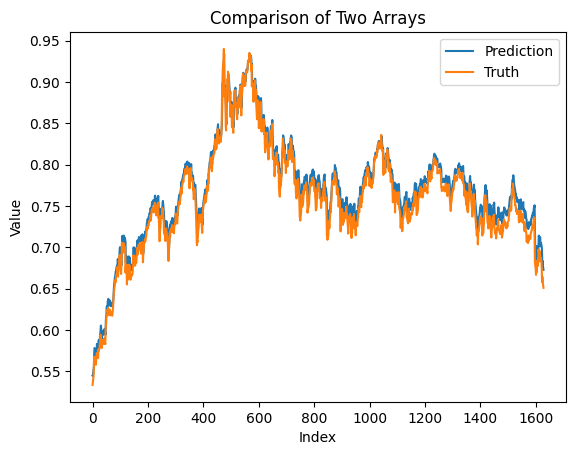

In [65]:
preds = model.predict(X_test)
print("MSE:", root_mean_squared_error(y_test, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_test, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE: 0.01399502791973855


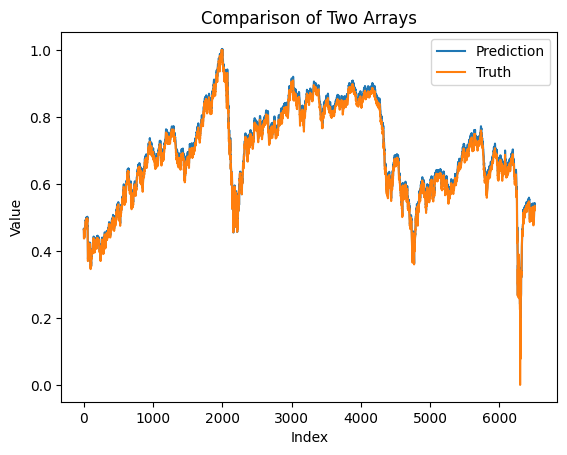

In [61]:
preds = model.predict(X_train)
print("MSE:", root_mean_squared_error(y_train, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_train, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()



In [62]:
def evaluate_by_steps( steps = 5, split = 0.8):
    X_seq, y_seq = create_sequences(data_scaler, target_y, steps)
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    n = len(X_seq[0][1])
    model = Sequential()
    model.add(Input(shape = (steps, n)))
    model.add(LSTM_GRU_Layer(LSTM_units = 128, GRU_units = 64, not_last_layer= False))

    losser = losses.MeanAbsoluteError()
    optimi = Adam(learning_rate= 0.01)
    model.compile(optimizer=optimi, loss=losser, metrics=['mae', 'mse'])
    
    callback = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=0, callbacks = [callback])

    preds_test = model.predict(X_test)
    rmse_test = root_mean_squared_error(y_test, preds_test)

    preds_truths = model.predict(X_train)
    rmse_truths = root_mean_squared_error(y_train, preds_truths)

    return rmse_test, rmse_truths

In [63]:
test_times = [5, 7, 10, 15, 30]
for t in test_times:
    result = evaluate_by_steps(t)
    print(f"With time_step = {t}, rmse test is {result[0]}, rmse train is {result[1]}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
With time_step = 5, rmse test is 0.019584593815984163, rmse train is 0.008625205081474966
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
With time_step = 7, rmse test is 0.009282667159274071, rmse train is 0.011155560970304488
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
With time_step = 10, rmse test is 0.010434527788661725, rmse train is 0.010383743815568627
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
With time_step = 15, rmse test is 0.020226712085233356, rmse train is 0.01102778158661585
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
With time_step = 30, rmse test is 0.012252733052481223, rmse train is 0.01337665118877396
